In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

# List of modifications applied to improve the accuracy of Queryset 
- Add an additional layer to the Siamese network and include batch normalization and dropout layers to reduce the likelihood of overfitting.
- Completely change the data loading process so that pairs are generated in batches and memory is released to prevent kernel crashes.
- Use early stopping and an adaptive learning rate `ReduceLROnPlateau` to achieve a robust training pipeline.
- Increase the number of shots in the support set.
- Implement contrastive loss; however, the results were unsatisfactory compared to the previous approach, so it was ignored.



# Hyperparameters


In [2]:
IMG_SIZE = 105  # Image size for resizing
BATCH_SIZE = 32
EPOCHS = 50

## Load and prepare Omniglot dataset

In [3]:

def load_omniglot():
    """
    Load the Omniglot dataset using TFDS.
    """
    (train_ds, test_ds), ds_info = tfds.load(
        'omniglot',
        split=['train', 'test'],
        as_supervised=True,
        with_info=True
    )
    return train_ds, test_ds, ds_info

def preprocess_image(image, label):
    """
    Resize and normalize the image.
    """
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [4]:
# Load and preprocess the dataset using TFDS
train_ds, test_ds, ds_info = load_omniglot()
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=1000)
# Batch the dataset so that we process one batch at a time (memory is released after each batch)
train_ds = train_ds.batch(BATCH_SIZE)

# --- Pair Generation ---


In [5]:


def generate_pairs_from_batch(images, labels):
    """
    Given a batch of images and labels (as NumPy arrays), generate pairs:
      - For each image, if possible, generate one positive pair (another image in the batch with the same label)
      - And one negative pair (an image with a different label)
    Returns:
        X1, X2: Arrays of images for the two branches (shape: [num_pairs, IMG_SIZE, IMG_SIZE, 3])
        pair_labels: Array of binary labels (1 for positive pairs, 0 for negative pairs)
    """
    images = images.numpy()  # Convert to numpy
    labels = labels.numpy()
    batch_pairs = []
    batch_pair_labels = []
    for i in range(len(images)):
        current_img = images[i]
        current_label = labels[i]
        # Positive pair: find another image in the batch with the same label
        pos_indices = np.where(labels == current_label)[0]
        if len(pos_indices) > 1:
            # Exclude the current index
            pos_indices = pos_indices[pos_indices != i]
            pos_idx = np.random.choice(pos_indices)
            pos_img = images[pos_idx]
            batch_pairs.append([current_img, pos_img])
            batch_pair_labels.append(1)
        # Negative pair: choose an image with a different label
        neg_indices = np.where(labels != current_label)[0]
        if len(neg_indices) > 0:
            neg_idx = np.random.choice(neg_indices)
            neg_img = images[neg_idx]
            batch_pairs.append([current_img, neg_img])
            batch_pair_labels.append(0)
    if len(batch_pairs) == 0:
        print("No pairs are generated")
        # In case no pairs are generated, return empty arrays
        return (np.empty((0, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32),
                np.empty((0, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32),
                np.empty((0,), dtype=np.int32))
    # Stack pairs into a uniform array
    pairs_array = np.stack(batch_pairs, axis=0)  # Shape: (num_pairs, 2, IMG_SIZE, IMG_SIZE, 3)
    X1 = pairs_array[:, 0]
    X2 = pairs_array[:, 1]
    return X1.astype(np.float32), X2.astype(np.float32), np.array(batch_pair_labels, dtype=np.int32)

def pair_generator_from_batch(images, labels):
    """
    Wrap generate_pairs_from_batch into a function that can be mapped over a tf.data.Dataset.
    """
    X1, X2, pair_labels = tf.py_function(
        func=generate_pairs_from_batch,
        inp=[images, labels],
        Tout=[tf.float32, tf.float32, tf.int32]
    )
    # Set static shapes. The first dimension is unknown (None) because it depends on the batch.
    X1.set_shape([None, IMG_SIZE, IMG_SIZE, 3])
    X2.set_shape([None, IMG_SIZE, IMG_SIZE, 3])
    pair_labels.set_shape([None])
    return (X1, X2), pair_labels

In [6]:
# Map the pairing function onto each batch.
pairs_ds = train_ds.map(pair_generator_from_batch, num_parallel_calls=tf.data.AUTOTUNE)
# Filter out any batches that did not generate pairs
pairs_ds = pairs_ds.filter(lambda x, y: tf.shape(x[0])[0] > 0)
pairs_ds = pairs_ds.prefetch(tf.data.AUTOTUNE)

# --- Build the Siamese Network ---

In [7]:
def build_feature_extractor():
    """
    Build the convolutional feature extractor.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5)
    ])
    return model

def build_siamese_network():
    """
    Build and compile the Siamese network.
    """
    feature_extractor = build_feature_extractor()
    input_a = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    input_b = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    feat_a = feature_extractor(input_a)
    feat_b = feature_extractor(input_b)
    
    # Compute L1 (absolute) distance between features
    l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([feat_a, feat_b])
    x = layers.Dense(64, activation='relu')(l1_distance)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    siamese_network = models.Model(inputs=[input_a, input_b], outputs=output)
    siamese_network.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return siamese_network

siamese_network = build_siamese_network()

/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Optionally implement contrastive loss. howver, the accuracy didnot changed that much.

In [8]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    """
    Contrastive loss function.
    
    Arguments:
      y_true: 1 if the pair is similar, 0 if dissimilar.
      y_pred: Euclidean distance between the two feature embeddings.
      margin: The margin value for dissimilar pairs.
    
    Returns:
      A scalar loss value.
    """
    squared_pred = tf.square(y_pred)
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * squared_pred + (1 - y_true) * margin_squared)

def build_siamese_network2():
    """
    Build and compile the Siamese network using contrastive loss.
    """
    feature_extractor = build_feature_extractor()
    
    # Define two inputs
    input_a = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    input_b = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Extract features from both inputs
    feat_a = feature_extractor(input_a)
    feat_b = feature_extractor(input_b)
    
    # Compute Euclidean distance between the two feature vectors
    distance = layers.Lambda(
        lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True))
    )([feat_a, feat_b])
    
    # Create the Siamese network model
    siamese_network = models.Model(inputs=[input_a, input_b], outputs=distance)
    
    # Compile the network with contrastive loss
    siamese_network.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=contrastive_loss
    )
    return siamese_network

siamese_network2 = build_siamese_network2()

# === Model Training ===


In [9]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("siamese_best_model.h5", monitor='loss', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = siamese_network.fit(
    pairs_ds,
    epochs=EPOCHS,
    steps_per_epoch=100,  
    callbacks=callbacks
)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5125 - loss: 0.9951

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.5124 - loss: 0.9949 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5255 - loss: 0.9248

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.5256 - loss: 0.9248 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5536 - loss: 0.8660

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.5536 - loss: 0.8658 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5639 - loss: 0.8109

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.5639 - loss: 0.8108 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5958 - loss: 0.7327

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.5958 - loss: 0.7328 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6114 - loss: 0.7130

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.6115 - loss: 0.7128 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6468 - loss: 0.7267 - learning_rate: 1.0000e-04
Epoch 8/50


/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6375 - loss: 0.6766

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.6376 - loss: 0.6764 - learning_rate: 1.0000e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6605 - loss: 0.6348

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6605 - loss: 0.6348 - learning_rate: 1.0000e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6826 - loss: 0.5957

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.6826 - loss: 0.5957 - learning_rate: 1.0000e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7166 - loss: 0.5342

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.7166 - loss: 0.5343 - learning_rate: 1.0000e-04
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7329 - loss: 0.5353

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.7330 - loss: 0.5352 - learning_rate: 1.0000e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7649 - loss: 0.4822

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.7649 - loss: 0.4821 - learning_rate: 1.0000e-04
Epoch 14/50
  3/100 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.7024 - loss: 0.4848

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7190 - loss: 0.4692 - learning_rate: 1.0000e-04
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.7797 - loss: 0.4626 - learning_rate: 1.0000e-04
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7949 - loss: 0.4431

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.7950 - loss: 0.4432 - learning_rate: 1.0000e-04
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8211 - loss: 0.4173

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.8209 - loss: 0.4174 - learning_rate: 1.0000e-04
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8316 - loss: 0.4158

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.8316 - loss: 0.4156 - learning_rate: 1.0000e-04
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8498 - loss: 0.3885

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.8498 - loss: 0.3885 - learning_rate: 1.0000e-04
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8730 - loss: 0.3454

100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.8730 - loss: 0.3454 - learning_rate: 1.0000e-04
Epoch 21/50
  3/100 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.8948 - loss: 0.3365

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8877 - loss: 0.3434 - learning_rate: 1.0000e-04
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8670 - loss: 0.3579

100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.8671 - loss: 0.3577 - learning_rate: 1.0000e-04
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8921 - loss: 0.3289

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.8921 - loss: 0.3289 - learning_rate: 1.0000e-04
Epoch 24/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8902 - loss: 0.3263

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.8902 - loss: 0.3262 - learning_rate: 1.0000e-04
Epoch 25/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8897 - loss: 0.3253

100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.8897 - loss: 0.3252 - learning_rate: 1.0000e-04
Epoch 26/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9092 - loss: 0.2869

100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.9092 - loss: 0.2867 - learning_rate: 1.0000e-04
Epoch 27/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9249 - loss: 0.2786

100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.9249 - loss: 0.2784 - learning_rate: 1.0000e-04
Epoch 28/50
  3/100 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9771 - loss: 0.2043

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9629 - loss: 0.2134 - learning_rate: 1.0000e-04
Epoch 29/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.9184 - loss: 0.2720 - learning_rate: 1.0000e-04
Epoch 30/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.9233 - loss: 0.2654 - learning_rate: 1.0000e-04
Epoch 31/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.9395 - loss: 0.2371 - learning_rate: 1.0000e-04
Epoch 32/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.9307 - loss: 0.2432 - learning_rate: 5.0000e-05
Epoch 33/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.9427 - loss: 0.2324 - learning_rate: 5.0000e-05


# ---Inference---

In [13]:
from collections import defaultdict
import matplotlib.pyplot as plt
import math

# Few-shot parameters
NUM_WAYS = 3     # 3 classes per episode
NUM_SHOTS = 3    # 3 examples per class for support set
NUM_QUERIES = 3  # 3 query examples per class

NUM_EPISODES = 25  # Evaluate over 25 episodes

siamese_net = siamese_network  
#siamese_net = siamese_network2  


In [14]:
def run_episode(NUM_WAYS = 3, NUM_SHOTS = 3, NUM_QUERIES = 3):
    """
    Create one episode with random support and query sets from Omniglot.
    Returns: support_images, support_labels, query_images, query_labels
    """
    ds = tfds.load('omniglot', split='test', as_supervised=True)
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()  

    # Convert dataset to a list for grouping 
    all_examples = list(tfds.as_numpy(ds))
    label_to_images = defaultdict(list)
    for img, label in all_examples:
        label_to_images[label].append(img)
    
    all_labels = list(label_to_images.keys())
    np.random.shuffle(all_labels)
    selected_labels = all_labels[:NUM_WAYS]
    
    support_images, support_labels = [], []
    query_images, query_labels = [], []
    
    for new_label, orig_label in enumerate(selected_labels):
        imgs = label_to_images[orig_label]
        np.random.shuffle(imgs)
        support = imgs[:NUM_SHOTS]
        query = imgs[NUM_SHOTS:NUM_SHOTS + NUM_QUERIES]
        support_images.extend(support)
        query_images.extend(query)
        support_labels.extend([new_label] * NUM_SHOTS)
        query_labels.extend([new_label] * NUM_QUERIES)
    
    support_images = np.stack(support_images)
    query_images = np.stack(query_images)
    support_labels = np.array(support_labels)
    query_labels = np.array(query_labels)
    
    return support_images, support_labels, query_images, query_labels


def classify_images(support_images, query_images, model, num_ways=NUM_WAYS, num_shots=NUM_SHOTS):
    predictions = []
    for query_img in query_images:
        query_img_expanded = tf.expand_dims(query_img, axis=0)
        tiled_query = np.tile(query_img_expanded, (support_images.shape[0], 1, 1, 1))
        scores = model.predict([tiled_query, support_images], verbose=0)
        aggregated_scores = np.zeros(num_ways)
        for i in range(num_ways):
            aggregated_scores[i] = np.mean(scores[i * num_shots:(i + 1) * num_shots])
        predicted_class = np.argmax(aggregated_scores)
        predictions.append(predicted_class)
    return predictions

Episode 1: Accuracy = 100.00%
Episode 2: Accuracy = 100.00%
Episode 3: Accuracy = 77.78%
Episode 4: Accuracy = 55.56%
Episode 5: Accuracy = 77.78%
Episode 6: Accuracy = 66.67%
Episode 7: Accuracy = 88.89%
Episode 8: Accuracy = 88.89%
Episode 9: Accuracy = 100.00%
Episode 10: Accuracy = 88.89%
Episode 11: Accuracy = 100.00%
Episode 12: Accuracy = 88.89%
Episode 13: Accuracy = 88.89%
Episode 14: Accuracy = 55.56%
Episode 15: Accuracy = 100.00%
Episode 16: Accuracy = 100.00%
Episode 17: Accuracy = 100.00%
Episode 18: Accuracy = 88.89%
Episode 19: Accuracy = 88.89%
Episode 20: Accuracy = 100.00%
Episode 21: Accuracy = 88.89%
Episode 22: Accuracy = 77.78%
Episode 23: Accuracy = 77.78%
Episode 24: Accuracy = 88.89%
Episode 25: Accuracy = 100.00%

Mean Accuracy over 25 episodes: 87.56% ± 13.08%


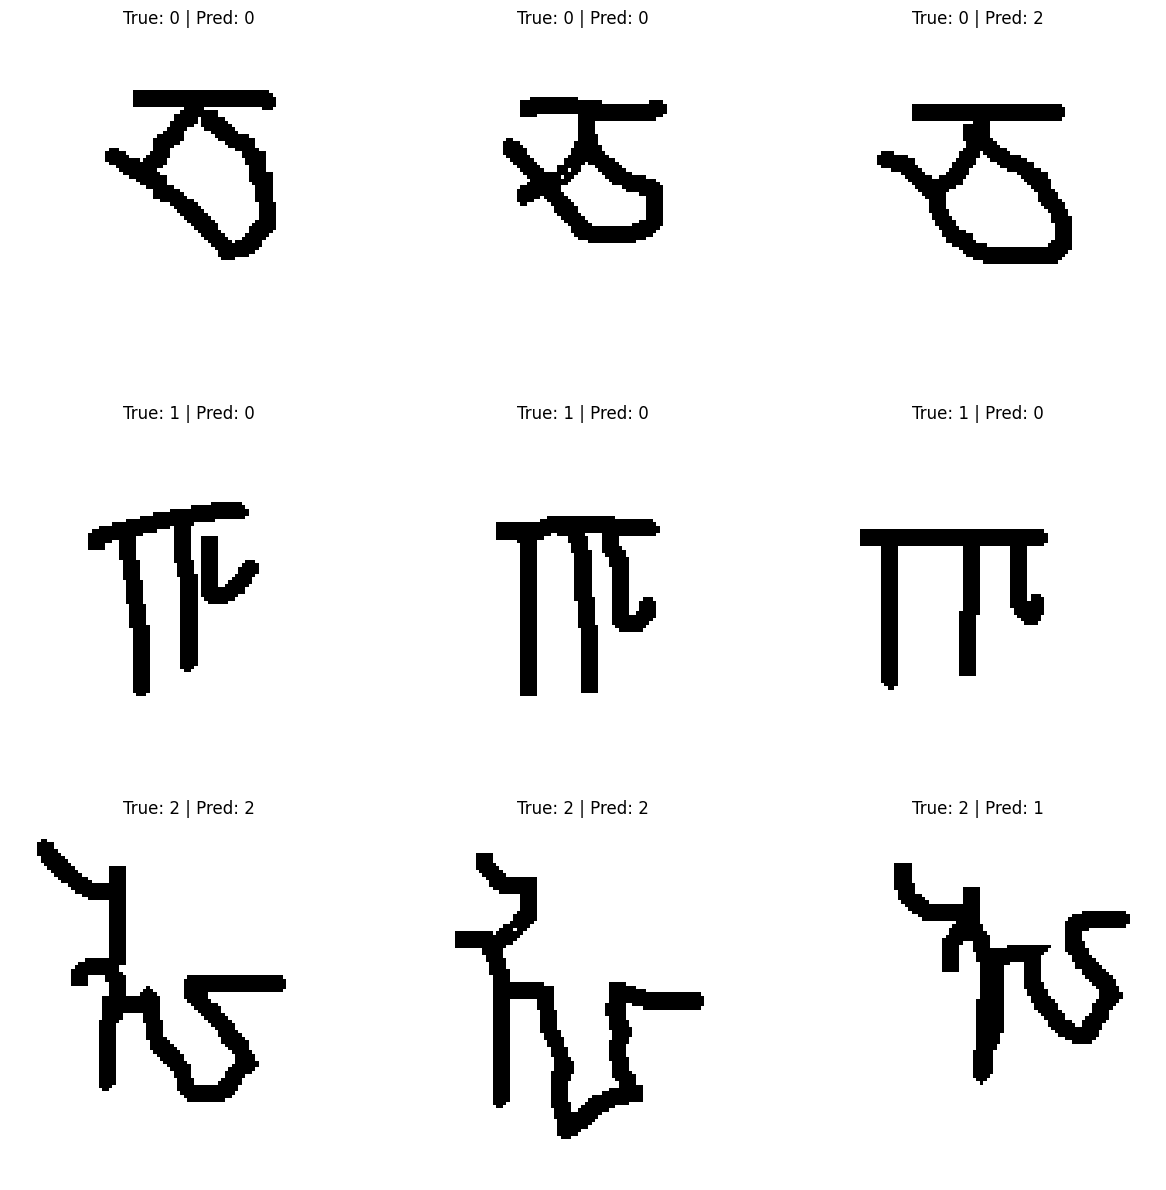

In [15]:
# Evaluate over multiple episodes
episode_accuracies = []
for episode in range(NUM_EPISODES):
    support_images, support_labels, query_images, query_labels = run_episode()
    predicted_classes = classify_images(support_images, query_images, siamese_net)
    acc = np.mean(np.array(predicted_classes) == query_labels)
    episode_accuracies.append(acc)
    print(f"Episode {episode+1}: Accuracy = {acc * 100:.2f}%")

mean_accuracy = np.mean(episode_accuracies)
std_accuracy = np.std(episode_accuracies)
print(f"\nMean Accuracy over {NUM_EPISODES} episodes: {mean_accuracy * 100:.2f}% ± {std_accuracy * 100:.2f}%")

support_images, support_labels, query_images, query_labels = run_episode()
predicted_classes = classify_images(support_images, query_images, siamese_net)

num_queries_total = query_images.shape[0]
cols = 3
rows = math.ceil(num_queries_total / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < num_queries_total:
        ax.imshow(query_images[i])
        ax.set_title(f"True: {query_labels[i]} | Pred: {predicted_classes[i]}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()
